In [1]:
__credits__ = ["Kallinteris-Andreas"]

import os
import warnings

import math
import numpy as np
import pytest
import random

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseRightEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    右旋回を行う動作をより良くするタスク．\n
    mujoco envを継承しています．
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/mouse_in_zigzag_maze.xml", frame_skip=1, **kwargs):
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = 11 #self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，サイズを指定したいので，サイズを取る
        # self.wall_hit = 0
        #マイクロマウスのパラメータ用変数
        self.reward_graph = []
        self.mouse_xpos_graph = []
        self.mouse_ypos_graph = []
        self.mouse_angle_rad = math.pi/2
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.mouse_vel = 0
        self.now_time = 0
        self.past_time = 0
        self.delta_t = 0
        self.wheel_r = 0
        self.gear = 9.0e-3
        self.wheel_r = 0.0135
        self.tread = 0.072
        self.right_rotation_sum = 0
        self.left_rotation_sum = 0
        self.stepcount = 0
        self.angsum_obs = 0
        


        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64
        )

    def get_odom(self, model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        odm_right = data.actuator('right').length[0]/self.gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
        odm_left = data.actuator('left').length[0]/self.gear # ＝タイヤの角度
        vel_left = data.actuator('left').velocity[0]/self.gear # ＝タイヤの回転角速度
        return odm_right, odm_left
    
    def get_pulse_count(self, pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
        """
            回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
            Returns:
                right_pulse_num = 右タイヤのパルス数 \\
                left_pulse_num = 左タイヤのパルス数
            """
        
        pre_right_rotation_sum = self.right_rotation_sum
        pre_left_rotation_sum = self.left_rotation_sum
        self.right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        self.left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        right_pulse_num = int(self.right_rotation_sum) - int(pre_right_rotation_sum)
        left_pulse_num = int(self.left_rotation_sum) - int(pre_left_rotation_sum)
        # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
        return right_pulse_num, left_pulse_num
    
    def get_odom_at_pulse(self, right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        right_wheel_move = 2*math.pi * self.wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
        left_wheel_move = 2*math.pi * self.wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
        right_wheel_vel = right_wheel_move/self.delta_t #移動距離から，速度を求める
        left_wheel_vel = left_wheel_move/self.delta_t #移動距離から，速度を求める
        mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
        mouse_radvel = (right_wheel_vel - left_wheel_vel)/self.tread #これがマウスの旋回角速度（rad/s）
        return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた

    def step(self, action):
        wall_hit = 0
        course_out = 0
        goal = 0
        velocity_before = self.data.sensor("Veloci").data[0] # 前の速度を取る
        ####オドメトリ####
        self.past_time = self.data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = self.get_odom(self.model, self.data)
        
        self.do_simulation(action, self.frame_skip)####################シミュレーション実行##############################
        self.now_time = self.data.time
        self.delta_t = self.now_time - self.past_time #シミュレーションが1ステップ終わった後の時間を取得
        self.past_time = self.now_time
        # エンコーダをもう一度読み取る　（行動後の値を取得）
        odm_right, odm_left = self.get_odom(self.model, self.data)
        # エンコーダ値から，この一瞬に出たパルス数を算出し，
        right_pulse_num, left_pulse_num = self.get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
        # パルス数から，移動速度と角速度を求める
        mouse_vel, mouse_rad_vel = self.get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
        # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        self.mouse_angle_rad += mouse_rad_vel * self.delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
        # print("関数内は：", mouse_angle_rad)
        self.mouse_xpos += mouse_vel * math.cos(self.mouse_angle_rad) * self.delta_t #オドメトリで座標推定
        self.mouse_ypos += mouse_vel * math.sin(self.mouse_angle_rad) * self.delta_t
        # self.mouse_xpos_graph.append(self.mouse_xpos)
        # self.mouse_ypos_graph.append(self.mouse_ypos)
        ####オドメトリ####

        velocity_after = self.data.sensor("Veloci").data[0] # 今の速度を取る
        mouse_vel = velocity_after - velocity_before
        # if mouse_vel < 0:
        #     3*mouse_vel
        self.mouse_vel = mouse_vel
        

        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        center_sensor = ls - rs

        hit_wall_f = self.data.sensor("HB1").data[0] #フォースセンサの値取得
        hit_wall_b = self.data.sensor("HB2").data[0] #フォースセンサの値取得
        truncated = False
        # print("hit wall", hit_wall_f, hit_wall_b)
        if hit_wall_f > 0 or hit_wall_b > 0:
            # print("hit")
            # self.wall_hit = -10
            wall_hit = -1
            # print("hit wall", hit_wall_f, hit_wall_b)
            truncated = True
        # mouse_Zpos = self.data.qpos[2] 
        # mouse_Ypos = self.data.qpos[1]
        # mouse_Xpos = self.data.qpos[0]
        # print("mouse_Zpos", mouse_Zpos)
        # print("mouse_Ypos", mouse_Ypos)
        # print("mouse_Xpos", mouse_Xpos)
        # if mouse_Zpos < -0.1:
        #     course_out = -1
        #     # print("course_out")
        #     truncated = True
        # if mouse_Ypos < 0.26 or mouse_Ypos > 0.28:
        #     course_out = -1
        #     # print("course_out")
        #     truncated = True
        # if mouse_Xpos < 0.26 or mouse_Xpos > 0.28:
        #     course_out = -1
        #     # print("course_out")
        #     truncated = True

        # print("摩擦！！！！", self.model.geom_friction)

        
        center_x = self.init_qpos[0] #座標を取得
        center_y = self.init_qpos[1] #座標を取得
        range_center_x = abs(self.data.qpos[0] - center_x)
        range_center_y = abs(self.data.qpos[1] - center_y)
        range_reward_x = 1/(1 + 1*range_center_x)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        range_reward_y = 1/(1 + 1*range_center_y)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる

        mokuhyou_ang = np.array([1, 0, 0, 0]) ## 目標角度設定　　右向き：[1, 0, 0, 0] 左向き：[6.123233995736766e-17 , 0, 0, 1] #正面：[0.70710678 0.         0.         0.70710678]
        
        mokuhyou_angx, mokuhyou_angy, mokuhyou_angz = self.quaternion_to_euler_numpy(mokuhyou_ang)
        z_mokuhyou_ang = mokuhyou_angz
        
        genzai_ang = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        ang_error = np.abs(genzai_ang - z_mokuhyou_ang)
        
        ang_reward = 1/(ang_error + 1) #ang_errorが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        # print("ang_reward", ang_reward)
        print("gymstepのangsum_obs:", self.angsum_obs)
        observation = self._get_obs(self.angsum_obs)
        reward = wall_hit + course_out + range_reward_x +range_reward_y + ang_reward[2] -0.5* np.sum(np.square(action)) #self.wall_hitにしないほうが見通しが良い気がする
        # print("wall_hit:",wall_hit , "course_out:", course_out, "range_reward:", range_reward, "ang_reward:", ang_reward)
        self.reward_graph.append(reward)
        info = {}
        
        
            
        if self.render_mode == "human":
            self.render()
        # print("reward", reward)
        reward = float(reward)
        return observation, reward, False, truncated, info
    
    def quaternion_to_euler_numpy(self, quaternion):
        """
        Converts a quaternion into Euler angles (roll, pitch, yaw) using numpy
        :param quaternion: A numpy array or list with the quaternion components [w, x, y, z]
        :return: A tuple of three angles: roll, pitch, yaw
        """
        w, x, y, z = quaternion
        norm = np.linalg.norm(quaternion)

        # 四元数がゼロまたは非常に小さい場合のチェック
        if np.isclose(norm, 0):
            return 0.0, 0.0, 0.0

        w, x, y, z = w / norm, x / norm, y / norm, z / norm

        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)

        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if np.abs(sinp) >= 1:
            # sinpが-1から1の範囲外の場合
            pitch = np.copysign(np.pi / 2, sinp)
        else:
            pitch = np.arcsin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)

        # ラジアンを度に変換
        deg_roll = np.degrees(roll)
        deg_pitch = np.degrees(pitch)
        deg_yaw = np.degrees(yaw)

        return deg_roll, deg_pitch, deg_yaw


    # def _get_obs(self): #状態空間を取得
    #     position = self.data.qpos[0:9].flat.copy()
    #     # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
    #     lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
    #     ls = np.array([self.data.sensor('LS').data[0]])
    #     rs = np.array([self.data.sensor('RS').data[0]])
    #     rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
    #     gyro = np.array([self.data.sensor('Gyro').data])
    #     accelerometer = np.array([self.data.sensor('Accel').data])
    #     gyro_0 = np.array([gyro[0][0]])
    #     gyro_1 = np.array([gyro[0][1]])
    #     gyro_2 = np.array([gyro[0][2]])
    #     accelerometer_0 = np.array([accelerometer[0][0]])
    #     accelerometer_1 = np.array([accelerometer[0][1]])
    #     accelerometer_2 = np.array([accelerometer[0][2]])
    #     mouse_angle_rad = np.array([self.mouse_angle_rad])
    #     mouse_xpos = np.array([self.mouse_xpos])
    #     mouse_ypos = np.array([self.mouse_ypos])
    #     mouse_vel = np.array([self.mouse_vel])
    #     return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
    
    def _get_obs(self, angsum_obs): #状態空間を取得
        angsum_obs = np.array([angsum_obs])
        # position = self.data.qpos[0:9].flat.copy()
        # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
        ls = np.array([self.data.sensor('LS').data[0]])
        rs = np.array([self.data.sensor('RS').data[0]])
        rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
        gyro = np.array([self.data.sensor('Gyro').data])
        gyro_0 = np.array([gyro[0][0]])
        gyro_1 = np.array([gyro[0][1]])
        gyro_2 = np.array([gyro[0][2]])
        accelerometer = np.array([self.data.sensor('Accel').data])
        accelerometer_0 = np.array([accelerometer[0][0]])
        accelerometer_1 = np.array([accelerometer[0][1]])
        accelerometer_2 = np.array([accelerometer[0][2]])
        # mouse_angle_rad = np.array([self.mouse_angle_rad])
        # mouse_xpos = np.array([self.mouse_xpos])
        # mouse_ypos = np.array([self.mouse_ypos])
        # mouse_vel = np.array([self.mouse_vel])
        # return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        return np.concatenate((angsum_obs, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
    
    def get_obs(self, angsum_obs): #状態空間を取得
        angsum_obs = np.array([angsum_obs])
        # position = self.data.qpos[0:9].flat.copy()
        # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
        ls = np.array([self.data.sensor('LS').data[0]])
        rs = np.array([self.data.sensor('RS').data[0]])
        rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
        gyro = np.array([self.data.sensor('Gyro').data])
        gyro_0 = np.array([gyro[0][0]])
        gyro_1 = np.array([gyro[0][1]])
        gyro_2 = np.array([gyro[0][2]])
        accelerometer = np.array([self.data.sensor('Accel').data])
        accelerometer_0 = np.array([accelerometer[0][0]])
        accelerometer_1 = np.array([accelerometer[0][1]])
        accelerometer_2 = np.array([accelerometer[0][2]])
        # mouse_angle_rad = np.array([self.mouse_angle_rad])
        # mouse_xpos = np.array([self.mouse_xpos])
        # mouse_ypos = np.array([self.mouse_ypos])
        # mouse_vel = np.array([self.mouse_vel])
        # return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        return np.concatenate((angsum_obs, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        
    def reset_model(self):
        qpos = self.init_qpos
        # print("qpos", qpos)
        qvel = self.init_qvel
        self.stepcount = 0
        

        # leftwall_on = np.random.uniform(0, 1)
        # rightwall_on = np.random.uniform(0, 1)
        # forwardwall_on = np.random.uniform(0, 1)
        # backwall_on = np.random.uniform(0, 1)
        # if leftwall_on >= 0.5:
        #     qpos[-1] = -0.4
        # else:
        #     qpos[-1] = 0
        # if rightwall_on >= 0.5:
        #     qpos[-2] = 0.4
        # else:
        #     qpos[-2] = 0
        # if forwardwall_on >= 0.5:
        #     qpos[-3] = 0.4
        # else:
        #     qpos[-3] = 0
        # if backwall_on >= 0.5:
        #     qpos[-4] = -0.4
        # else:
        #     qpos[-4] = 0
        # x_values = [0.27, 1.07, 1.87]
        # mouse_xposition_shuffle = random.choice(x_values)
        # x_values = 0.27

        # mouse_xposition_shuffle = self.course_list[np.random]
        # mouse_yposition_shuffle = self.course_list[np.random]

        #両方3のときはやり直しする処理
        
        # qpos[0] = mouse_xposition_shuffle
        # qpos[0] = x_values
        # noise = np.random.normal(0, 0.3)  # 平均0、標準偏差0.1のノイズ
        # qpos[3] += np.random.normal(0, 0.03)#0.27 1.07
        # qpos[1] = mouse_yposition_shuffle
        self.set_state(qpos, qvel) #qposとqvelには，すべての位置と速度の値がならんでいるためそれをセットする
        self.mouse_angle_rad = 0
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        
        self.angsum_obs = 0

        observation = self._get_obs(self.angsum_obs)

        return observation

    def _get_reset_info(self):
        return {"works": True}
    
    # from typing import Any, Dict, Optional, Tuple, Union
    # def reset(
    #     self,
    #     *,
    #     seed: Optional[int] = None,
    #     options: Optional[dict] = None,
    # ):
    #     super().reset(seed=seed) #サブクラスにresetを書くとそちらだけが実行されるように隠蔽されてしまうので，スーパークラスのresetを実行して，前に定義した内容も実行する

    #     self._reset_simulation()
    #     print("リセットメソッドのオーバーライドができているか確認するためのprint文です．")

    #     ob = self.reset_model()
    #     info = self._get_reset_info()

    #     if self.render_mode == "human":
    #         self.render()
    #     return ob, info


CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseRightEnv(frame_skip=frame_skip)

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseRightEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseRightEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseRightEnv()

    _, info = env.reset()
    assert info["works"] is True

#環境登録
import gymnasium as gym
gym.envs.registration.register(id='MouseRightEnv-v0',max_episode_steps=600,entry_point=MouseRightEnv)

import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human")

# model = PPO("MlpPolicy", env, verbose=0)
RLmodel = PPO.load('okiro',env)

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
import time
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import glfw
import keyboard
import math



def action(model, data, left, right):
    if left > 3:
        left = 3
    if right > 3:
        right = 3
    data.actuator('right').ctrl[0] = right
    data.actuator('left').ctrl[0] = left

def quaternion_to_euler_numpy(quaternion):
    """
    Converts a quaternion into Euler angles (roll, pitch, yaw) using numpy
    :param quaternion: A numpy array or list with the quaternion components [w, x, y, z]
    :return: A tuple of three angles: roll, pitch, yaw
    """
    w, x, y, z = quaternion
    norm = np.linalg.norm(quaternion)

    # 四元数がゼロまたは非常に小さい場合のチェック
    if np.isclose(norm, 0):
        return 0.0, 0.0, 0.0

    w, x, y, z = w / norm, x / norm, y / norm, z / norm

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if np.abs(sinp) >= 1:
        # sinpが-1から1の範囲外の場合
        pitch = np.copysign(np.pi / 2, sinp)
    else:
        pitch = np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    # ラジアンを度に変換
    deg_roll = np.degrees(roll)
    deg_pitch = np.degrees(pitch)
    deg_yaw = np.degrees(yaw)

    return deg_roll, deg_pitch, deg_yaw

def get_distance(model, data):
    lf = data.sensor('LF').data[0]#sensordata[lf_id]
    ls = data.sensor('LS').data[0]#sensordata[ls_id]
    rs = data.sensor('RS').data[0]#sensordata[rs_id]
    rf = data.sensor('RF').data[0]#sensordata[rf_id]
    if lf < -0.1:
      lf = 0.23
    if ls < -0.1:
      ls = 0.23
    if rs < -0.1:
      rs = 0.23
    if rf < -0.1:
      rf = 0.23
    return lf,ls,rs,rf

def get_accel(model, data):
  ax = data.sensor('Accel').data[0]
  ay = data.sensor('Accel').data[1]
  az = data.sensor('Accel').data[2]
  return ax,ay,az

def get_gyro(model, data):
  gx = data.sensor('Gyro').data[0]
  gy = data.sensor('Gyro').data[1]
  gz = data.sensor('Gyro').data[2]
  return gx,gy,gz

def get_odom(model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  vel_left = data.actuator('left').velocity[0]/gear # ＝タイヤの回転角速度
  return odm_right, odm_left


def random_friction(model, data):
    if random.random() > 0.8:
        model.geom_friction[:] = 1
    else:
        model.geom_friction[:] = random.uniform(0.14, 0.21) #0.14, 0.21
    # print("摩擦係数", model.geom_friction)
    mujoco.mj_forward(model, data)#mujocoのキャッシュを更新するための処理 iranai?


def get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
  """
    回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
    Returns:
        right_pulse_num = 右タイヤのパルス数 \\
          left_pulse_num = 左タイヤのパルス数
    """
  global right_rotation_sum
  global left_rotation_sum
  pre_right_rotation_sum = right_rotation_sum
  pre_left_rotation_sum = left_rotation_sum
  right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  right_pulse_num = int(right_rotation_sum) - int(pre_right_rotation_sum)
  left_pulse_num = int(left_rotation_sum) - int(pre_left_rotation_sum)
  # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
  return right_pulse_num, left_pulse_num

def get_odom_at_pulse(right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  right_wheel_move = 2*math.pi * wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
  left_wheel_move = 2*math.pi * wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
  right_wheel_vel = right_wheel_move/delta_t #移動距離から，速度を求める
  left_wheel_vel = left_wheel_move/delta_t #移動距離から，速度を求める
  mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
  mouse_radvel = (right_wheel_vel - left_wheel_vel)/tread #これがマウスの旋回角速度（rad/s）
  return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた



paused = False
def key_callback(keycode): #スペースキーで一時停止
  #９５％の確率で，摩擦１
  # ５％の確率で，摩擦０～０．７ いや，必要ありません
  if chr(keycode) == ' ':
    global paused #グローバル変数のpausedを使用できるように，この関数のスコープ内に取り込む処理
    paused = not paused #pausedの真偽値を逆にする　trueとfalseを反転


# def P_straight_control(model, data):#左右の壁による位置補正
#     now_speed_left = data.actuator('left').ctrl[0]
#     now_speed_right = data.actuator('right').ctrl[0]
#     lf, ls, rs, rf = get_distance(model, data)
    
#     sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
#     # print(sensor_diff)
#     left_mot = kp * -sensor_diff + 0.2
#     right_mot = kp * sensor_diff + 0.2
#     global turn_flag
#     if turn_flag==1 or (lf<0.07 and rf <0.07):
#         turn_flag = 1
#         right_mot =  0.06
#         left_mot  = -0.06
#         if lf > 0.09 and rf > 0.09:
#           turn_flag = 0
#     return left_mot, right_mot

#関数化で新しく作成した関数

def mj_step_loop(model, data, loop_num): #mujocoのシミュレーションを任意の数だけ行う関数 グラフ化するときに不便かもしれないから不必要かも
  for i in range(loop_num):
    action(model, data, left_mot, right_mot)#なくても変わらない？？
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    #Vizualize
    viz_now = data.time
    if viz_now-viz_past>0.01:
      viz_past = viz_now
      viewer.sync()

def straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,):#前進0.5マス
  #最初の前進
  straight_kp = kp #デフォルトのゲインにして，変更があったらそれを使う
  straight_ki = ki
  
  I_err_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？ 補正するからおけ
  target_vel = 0
  past_time = data.time
  # mouse_xpos = 0 #globalにして，引数で受け取ったものに足して言って，戻り値として座標を返すようにすべき？？
  # mouse_ypos = 0
  viz_past = 0 #globalにすべき??
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  for kagennsoku in range(3):
    target_add_num = [0.15,0,-0.15] #各区間での目標速度を入れておくリスト
    print("目標速度：",target_add_num[kagennsoku], "＃＃＃＃＃＃＃＃")
    for mokuhyou_zahyou_kousin in range(30):
      target_vel += target_add_num[kagennsoku]/30 #0から始まって，
      err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      # print("原因説err_vel：", err_vel)
      I_err_sum += err_vel
      lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
      rs_hosei = 0
      ls_hosei = 0
      if lf < 0.07 and rf < 0.07:
          left_mot = 0.0
          right_mot = 0.0 #0.07より近づかないようにする
      else:
          if rs < 0.1 and ls < 0.1: #両方に壁がある場合のみ，補正を追加 これで吸い込まれないようにする
             rs_hosei = 8*rs
             ls_hosei = 8*ls
          left_mot = straight_kp * err_vel + straight_ki * I_err_sum + rs_hosei
          right_mot = straight_kp * err_vel + straight_ki * I_err_sum + ls_hosei
      action(model, data, left_mot, right_mot)
      # 制御周期を遅くするため，シミュレーションを100回繰り返す
      random_friction(model, data)
      for seigyosyuuki_delay in range(100):
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)#################################################################
        # lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      #Vizualize　あんまり細かく描画しすぎないように，0.01秒以上経ってたら描画するようにする
      viz_now = data.time
      if viz_now-viz_past>0.1:
        viz_past = viz_now
        viewer.sync()
      
      now_time = data.time
      delta_t = now_time - past_time #シミュレーションが1ステップ終わった後の時間を取得
      past_time = now_time
      # エンコーダをもう一度読み取る　（行動後の値を取得）
      odm_right, odm_left = get_odom(model, data)
      # エンコーダ値から，この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
      # print("関数内は：", mouse_angle_rad)
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t #オドメトリで座標推定
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left 
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  model.geom_friction[:] = 1
  #前進動作終了時に，前壁との距離が0.09より離れていたら，少しだけ前進する
  lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
  if lf > 0.11 and rf > 0.11:
    for i in range(30):
      left_mot=0.02 #少しずつ前進
      right_mot=0.02
      for _ in range(50):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        if lf < 0.07 and rf < 0.07: #少しずつ前進してるときに十分近づいたらそれ以上近づかないようにする
          left_mot = 0.0
          right_mot = 0.0 #0.09より近づかないようにする
        action(model, data, left_mot, right_mot)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
        viewer.sync()
  #近づきすぎない調整も終わったら，今度は向きの調整をする
  lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
  front_err = lf - rf
  if abs(front_err) > 0.00001:
    print("調整入りました")
    for i in range(30):
      left_mot = front_err * 50 
      right_mot = -front_err * 50 #ズレを直そうとする
      for i in range(200): #実際に直す，しかしerrが十分小さくなったら動くのをやめる
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        front_err = lf - rf
        if abs(front_err) < 0.0001: #ある程度ズレが小さくなってきたら，それ以上直さないようにする
          left_mot = 0
          right_mot = 0
        action(model, data, left_mot, right_mot)
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left

def right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      random_friction(model, data)
      for seigyosyuuki in range(100):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  model.geom_friction[:] = 1
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left


def left_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      random_friction(model, data)
      # t_graph.append(data.time)
      for seigyosyuuki in range(100):
        lf,ls,rs,rf = get_distance(model, data) #各センサ値を取得
        lf_sensor_graph.append(lf)
        rf_sensor_graph.append(rf)
        ls_sensor_graph.append(ls)
        rs_sensor_graph.append(rs)
        left_mot_graph.append(left_mot)
        right_mot_graph.append(right_mot)
        zkakusokudo_rad = data.sensor('Gyro').data[2]
        zkakusokudo_ang = zkakusokudo_rad * 180 / math.pi
        kakusokudo_graph.append(zkakusokudo_ang)
        xyz = quaternion_to_euler_numpy(data.qpos[3:7])
        Z = xyz[2]
        kakudo_graph.append(Z)
        t_graph.append(data.time)
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      # right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
  model.geom_friction[:] = 1
  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left






#Create model
# model = mujoco.MjModel.from_xml_path('../mouse_in_maze.xml')
# data = mujoco.MjData(model)
model = env.model
data = env.data

odom_right_graph = []
mouse_correct_vel_graph = []

gear = 9.0e-3
wheel_r = 0.0135
tread = 0.072
mx = 0.0
my = 0.0
psi = 0.0
past_odom_right = 0.0
past_odom_left = 0.0
# kp = 100
# st_Kp = 1.55 #ダンピング3.6e-6のときの最適なゲイン
st_Kp = 8.4
rad_Kp = 0.15
rad_vel_Kp = 2

rad_Kd = 0.00001

ki6 = 0.02
kd = 0.09
I_err_sum = 0
d_grad = 0
prev_err_rad = 0
target_vel = 0
target_rad = math.pi/2
target_rad_vel = 0
mjstep_count = 0

right_pulse_num = 0
right_pulse_num_graph = []
left_pulse_num = 0
left_pulse_num_graph = []

right_rotation_sum = 0
left_rotation_sum = 0

mouse_vel = 0
mouse_rad_vel = 0
mouse_xpos = 0
mouse_xpos_graph = []
mouse_ypos = 0
mouse_ypos_graph = []
target_vel_graph = []
err_vel_graph = []
mouse_vel_graph = []

viz_now = 0.0
viz_past = 0.0
now_time = 0
past_time = 0
turn_flag = 0
x_vel = 0
y_vel = 0
z_vel = 0
err = 0
delta_t = 0.01
mouse_now_rad_xy = math.pi/2 #y軸方向を向いている
I_err_rad_vel_sum = 0
mouse_angle_rad = (math.pi/2)
right_mot = 0
left_mot = 0 #最初は0

#デバッグ用グラフのためのリスト
LRF_lf_graph = []
LRF_ls_graph = []
LRF_rs_graph = []
LRF_rf_graph = []
lf_sensor_graph = []
rf_sensor_graph = []
ls_sensor_graph = []
rs_sensor_graph = []
t_graph = []
kakusokudo_graph = []
kakudo_graph = []
right_mot_graph = []
left_mot_graph = []
x_vel_graph = []
velocimeter_graph = []
err_graph = []
err_rad_graph = []
gyro_graph = []
yzahyou = []
timevals = []
timevals5 = []
timevals6 = []
mouse_angle_rad_graph = []
mouse_correct_rad_vel_graph = []
mouse_rad_vel_graph = []
err_rad_vel_graph = []
target_rad_vel_graph = []
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer:
    pass

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.model` for environment variables or `env.get_wrapper_attr('model')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.data` for environment variables or `env.get_wrapper_attr('data')` that will search the reminding wrappers.
  logger.warn(


In [2]:
def RL_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
    r_turn_kp = kp
    r_turn_ki = ki
    mouse_xpos = 0
    mouse_ypos = 0
    env.angsum_obs = 0
    # env.model.opt.timestep = 0.01
    
    for _ in range(600):
        past_time = data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        before_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        obs = env.get_obs(env.angsum_obs) #今の[状態]を得る
        # print("おれのangsum_obs:", env.angsum_obs)
        # print(obs)
        Action, _ = RLmodel.predict(obs) #推論して，行動を受け取る
        left_mot = Action[0] #その行動司令を変数に渡して，
        right_mot = Action[1]
        action(model, data, left_mot, right_mot) #行動司令を正式にセットする
        # for seigyosyuuki in range(100):
        mujoco.mj_step(model, data, nstep=100) #その行動でなんステップかシミュレーションする
        env.mujoco_renderer.render(
            env.render_mode, env.camera_id, env.camera_name
        )
        viewer.sync()
        after_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        env.angsum_obs += after_ang[2] - before_ang[2]
        now_time = data.time# ΔTを求める
        delta_t = now_time - past_time
        past_time = now_time
        ####オドメトリ####
        odm_right, odm_left = get_odom(model, data) # エンコーダをもう一度読み取る
        right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# この一瞬に出たパルス数を算出し，
        mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度を求める#これで，エンコーダによるマウスの速度・角速度が推定できた
        mouse_angle_rad += mouse_rad_vel * delta_t # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
        mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
        pre_odm_right = odm_right# 一つ前のodom値を更新
        pre_odm_left = odm_left
        ####オドメトリ####
    env.angsum_obs = 0
    env.model.opt.timestep = 0.0001
    return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left



def RLstep_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
    r_turn_kp = kp
    r_turn_ki = ki
    mouse_xpos = 0
    mouse_ypos = 0
    env.angsum_obs = 0
    env.model.opt.timestep = 0.001
    
    for _ in range(1200):
        past_time = data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        before_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        obs = env.get_obs(env.angsum_obs) #今の[状態]を得る
        # print("obs:",obs)
        # obs = get_obs_for_predict(model, data, env.angsum_obs) #今の[状態]を得る
        # print("ちゃんとたされていってるはずのobs", obs)
        Action, _ = RLmodel.predict(obs) #推論して，行動を受け取る
        # print("推論時に渡したobs！:",obs, "推論結果の行動:",Action)
        left_mot = Action[0] #その行動司令を変数に渡して，
        right_mot = Action[1]
        env.step(Action)
        viewer.sync()
        after_ang = env.quaternion_to_euler_numpy(data.qpos[3:7])
        env.angsum_obs += after_ang[2] - before_ang[2]
        now_time = data.time# ΔTを求める
        delta_t = now_time - past_time
        past_time = now_time
        ####オドメトリ####
        odm_right, odm_left = get_odom(model, data) # エンコーダをもう一度読み取る
        right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# この一瞬に出たパルス数を算出し，
        mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度を求める#これで，エンコーダによるマウスの速度・角速度が推定できた
        mouse_angle_rad += mouse_rad_vel * delta_t # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
        mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
        pre_odm_right = odm_right# 一つ前のodom値を更新
        pre_odm_left = odm_left
        ####オドメトリ####
    env.angsum_obs = 0
    env.model.opt.timestep = 0.0001
    return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left



def reload_xy_by_odometly(pre_odm_right, pre_odm_left, mouse_angle_rad, mouse_xpos, mouse_ypos):
    odm_right, odm_left = get_odom(model, data) # エンコーダをもう一度読み取る
    right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)# この一瞬に出たパルス数を算出し，
    mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) # パルス数から，移動速度と角速度を求める#これで，エンコーダによるマウスの速度・角速度が推定できた
    mouse_angle_rad += mouse_rad_vel * delta_t # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
    mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
    mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
    pre_odm_right = odm_right# 一つ前のodom値を更新
    pre_odm_left = odm_left
    return mouse_angle_rad, mouse_xpos, mouse_ypos
    

In [3]:
#Main Loop
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(3) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  obs, _ = env.reset()
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = RL_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
  print("最初の１マス進む処理")
  target_vel = 0
  # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = left_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #左にカーブ
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
    
      



      
      left_mot = 0
      right_mot = 0
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      for seigyosyuuki2 in range(100):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

最初の１マス進む処理
-2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
調整入りました
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
調整入りました


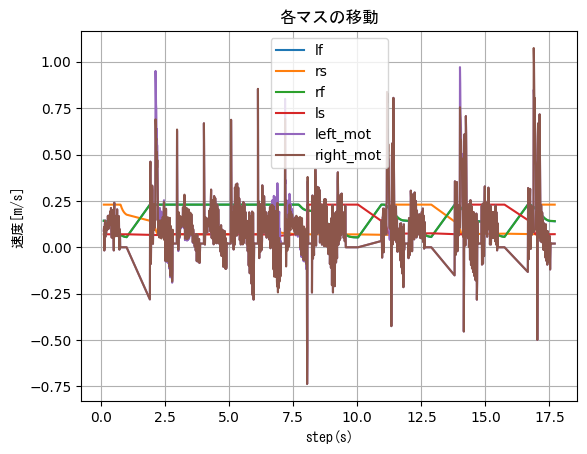

In [4]:
# print(video_path)
plt.title("各センサの値とモータ出力", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(left_mot_graph)))  # 0から始まるインデックスのリストを作成
plt.plot(t_graph, lf_sensor_graph, linestyle='solid', label="lf")
plt.plot(t_graph, rs_sensor_graph, linestyle='solid', label="rs")
plt.plot(t_graph, rf_sensor_graph, linestyle='solid', label="rf")
plt.plot(t_graph, ls_sensor_graph, linestyle='solid', label="ls")
plt.plot(t_graph, left_mot_graph, linestyle='solid', label="left_mot")
plt.plot(t_graph, right_mot_graph, linestyle='solid', label="right_mot")
plt.legend()

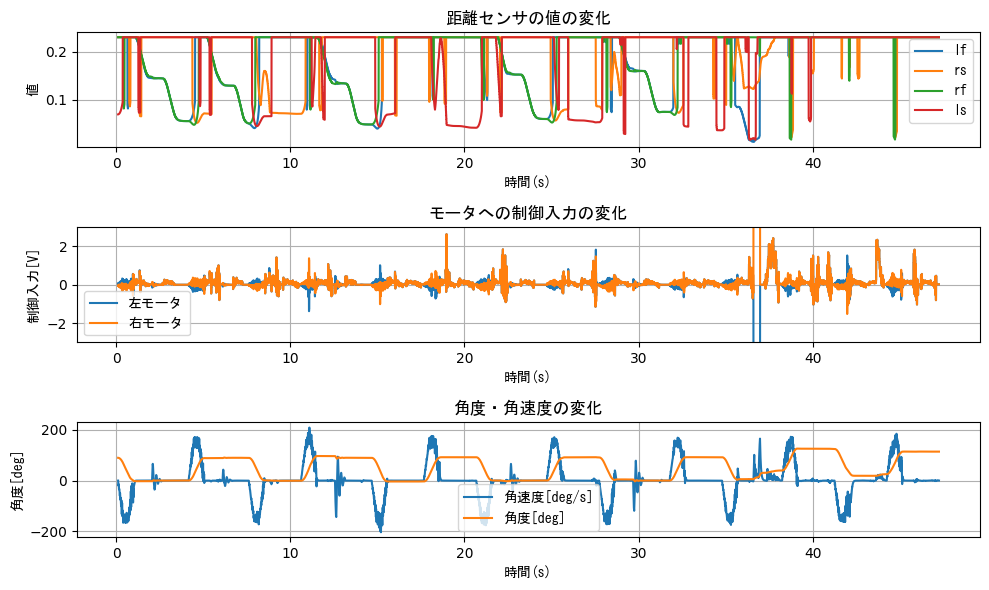

In [6]:
import matplotlib.pyplot as plt

# データの設定
# t_graph = list(range(len(left_mot_graph)))  # 仮定：left_mot_graph に適切なデータが入っている
# lf_sensor_graph, rs_sensor_graph, rf_sensor_graph, ls_sensor_graph,
# left_mot_graph, right_mot_graph にも適切なデータが入っていると仮定

plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# ４つの距離センサの値の変化をプロットするサブプロット
plt.subplot(3, 1, 1)  # 2行1列のうちの1番目
plt.title("距離センサの値の変化", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("値", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
plt.plot(t_graph, lf_sensor_graph, linestyle='solid', label="lf")
plt.plot(t_graph, rs_sensor_graph, linestyle='solid', label="rs")
plt.plot(t_graph, rf_sensor_graph, linestyle='solid', label="rf")
plt.plot(t_graph, ls_sensor_graph, linestyle='solid', label="ls")
plt.legend(prop={'family':'MS Gothic'})

# 制御入力の変化をプロットするサブプロット
plt.subplot(3, 1, 2)  # 2行1列のうちの2番目
plt.title("モータへの制御入力の変化", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("制御入力[V]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
plt.ylim(-3, 3)  # x軸の範囲を設定
plt.plot(t_graph, left_mot_graph, linestyle='solid', label="左モータ")
plt.plot(t_graph, right_mot_graph, linestyle='solid', label="右モータ")
plt.legend(prop={'family':'MS Gothic'})

# 角度と角速度の変化をプロットするサブプロット
plt.subplot(3, 1, 3)  # 2行1列のうちの2番目
plt.title("角度・角速度の変化", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間(s)", fontname="MS Gothic")
plt.ylabel("角度[deg]", fontname="MS Gothic")
# plt.xlim(4.0, 10.0)  # x軸の範囲を設定
plt.plot(t_graph, kakusokudo_graph, linestyle='solid', label="角速度[deg/s]")
plt.plot(t_graph, kakudo_graph, linestyle='solid', label="角度[deg]")
plt.legend(prop={'family':'MS Gothic'})

plt.tight_layout()  # サブプロット間のスペースを調整
plt.show()


In [ ]:
#Main Loop
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(3) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  obs, _ = env.reset()
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = RL_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
  print("最初の１マス進む処理")
  target_vel = 0
  # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得

      model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = left_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #左にカーブ
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
      model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進

      
      left_mot = 0
      right_mot = 0
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      for seigyosyuuki2 in range(100):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      
      # print(video_path)
# plt.title("角速度読み取り値比較", fontname="MS Gothic")
# plt.grid()
# plt.xlabel("角速度", fontname="MS Gothic")
# plt.ylabel("速度[m/s]", fontname="MS Gothic")

# #前進関係のプロット
# t1 = list(range(len(GOD_w_graph)))  # 0から始まるインデックスのリストを作成
# # t2 = list(range(len(gyro_psy_graph)))  # 0から始まるインデックスのリストを作成
# # plt.plot(t1, GOD_w_graph, linestyle='solid', label="髪視点")
# # plt.plot(t2, gyro_psy_graph, linestyle='solid', label="ジャイロ")
# plt.legend()
# 環境のクローズ
env.close()

In [3]:
#Main Loop
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(5) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  obs, _ = env.reset()
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = RL_right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
  print("最初の１マス進む処理")
  target_vel = 0
  # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  # model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      
    
      if ls > 0.12:
        print("左に壁がないとき")
        # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
      elif lf > 0.18 and rf > 0.18:
        print("前壁に壁がないとき")
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
      elif rs > 0.12:
        print("右に壁がないとき", mouse_vel)
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = left_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #左にカーブ
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
      
      else:
        print("その他の場合")
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #右にカーブ
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #右にカーブ
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)


      
      
      left_mot = 0
      right_mot = 0
      # mouse_xpos_graph.append(mouse_xpos)
      # mouse_ypos_graph.append(mouse_ypos)
      for seigyosyuuki2 in range(100):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

最初の１マス進む処理
右に壁がないとき 0
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 5.451323936336544e-18
ypos: 0.08902687599611528
-2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
xpos: 0.00018507261420612058
ypos: 0.09127975165699485
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 0.09523478523168741
ypos: 0.09048634979297626
前壁に壁がないとき
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 0.19066049463397883
ypos: 0.09042891057000453
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 0.2861276943917663
ypos: 0.09056174244870487
前壁に壁がないとき
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 0.38165706296899304
ypos: 0.09066065335757904
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
xpos: 0.4770104121420982
ypos: 0.09075503253511732
前壁に壁がないとき
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
調整入りました
xpos: 0.568677589782554
ypos: 0.09085665552336318
目